# Pipeline Describe
- Download Data
- Load Data
- Analyze trend and cycle
- Transform for stationarity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller, arma_order_select_ic
import itertools
import warnings


#Own packages
import download
import descriptive
# import models
# import model_wrapper

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [3]:
params = {
    'outcome_col': 'ing_trib_sin_gasol_neto_(mdp)_r',
    'nombre_legible': 'Ingresos Tributarios neto (sin IEPS gasolina)'}

In [4]:
# Importamos csv con ingresos netos
ingresos_totales = download.load_ingresos_fiscales('../inputs/ingresos_tributarios_desglosados_updated.xlsx')

# Igaes
igae = download.load_inegi_indic('igae')

# Ocupación
pea = download.load_inegi_indic('pea')
pobl_ocupada = download.load_inegi_indic('pobl_ocupada')
asegurados_imss = download.load_inegi_indic('asegurados_imss')

# Tipo de cambio
tc_mensual = download.load_banxico('tc_mensual')

# Tasas de interés
tasa_cetes_91_mensual = download.load_banxico('tasa_cetes_91_mensual')
tbill_3meses_mensual = download.load_fed('tbill_3meses_mensual')

# Precios
cons_price_index_us = download.load_fed('cons_price_index_us')
inpc = download.load_inpc()

# Indicadores US
ind_prod_ind_us = download.load_fed('ind_prod_ind_us')

#PIB real US
pib_r_us = download.load_fed('pibr_us_2012', monthly = True)

# Semana santa
semana_santa = pd.read_excel('../inputs/semana_santa.xlsx', index_col='fecha')
semana_santa['semana_santa'] = 1
semana_santa = semana_santa.reindex(pd.date_range('1990-01-01', '2022-12-01', freq='MS'))
semana_santa = semana_santa.fillna(0)

## Creamos columna de otros ingresos tributarios

In [61]:
ingresos_totales['otros_ingresos_tributarios_neto_(mdp)_r'] = \
ingresos_totales['ing_trib_neto_(mdp)_r'] - \
ingresos_totales[['ieps_sin_gas_neto_(mdp)_r', 'ieps_gasolina_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',
                  'isr_neto_(mdp)_r', 'iva_neto_(mdp)_r']].sum(1)

## Grupos de columnas útiles

In [84]:
cols_ingresos_gob_federal = ['ing_gob_fed_neto_(mdp)_r',
                             'ing_trib_sin_gasol_neto_(mdp)_r',\
                             'ing_no_trib_neto_(mdp)_r',\
                             'ieps_gasolina_neto_(mdp)_r']
cols_ingresos_tributarios_principales = \
                            ['ing_trib_sin_gasol_neto_(mdp)_r',
                             'isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',\
                             'ieps_gasolina_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',
                             'otros_ingresos_tributarios_neto_(mdp)_r']
cols_ingresos_tributarios_relevantes = \
                            ['ing_trib_sin_gasol_neto_(mdp)_r',
                             'isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',
                             'importaciones_neto_(mdp)_r']
cols_solo_impuestos = \
                            ['isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',\
                             'ieps_gasolina_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',
                             'otros_ingresos_tributarios_neto_(mdp)_r']
cols_ingresos_tributarios_totaless = \
                            ['ing_trib_sin_gasol_neto_(mdp)_r',
                             'isr_neto_(mdp)_r', 'iva_neto_(mdp)_r', 'ieps_sin_gas_neto_(mdp)_r',\
                             'ieps_gasolina_neto_(mdp)_r', 'importaciones_neto_(mdp)_r',\
                             'impuesto_extraccion_hidrocarburos_neto_(mdp)_r', 'isan_neto_(mdp)_r',\
                             'accesorios_contribuciones_neto_(mdp)_r', 'otros_ingresos_tributarios_neto_(mdp)_r']

## Describing Data

In [63]:
ingresos_totales.columns

Index(['ingresos_sector_publico_neto_(mdp)', 'ieps_neto_(mdp)',
       'ieps_sin_gas_neto_(mdp)', 'ing_gob_fed_neto_(mdp)',
       'ing_trib_neto_(mdp)', 'isr_neto_(mdp)', 'iva_neto_(mdp)',
       'importaciones_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ieps_hidrocarburos_neto_(mdp)',
       ...
       'isr_comp_%bruto', 'isr_dev_%bruto', 'isr_reg_%bruto',
       'isr_dev_comp_%bruto', 'isr_dev_comp_reg_%bruto', 'ieps_comp_%bruto',
       'ieps_dev_%bruto', 'ieps_reg_%bruto', 'ieps_dev_comp_%bruto',
       'ieps_dev_comp_reg_%bruto'],
      dtype='object', length=121)

In [64]:
display(ingresos_totales.columns)
display(ingresos_totales.shape)
display(ingresos_totales.isnull().any())
display(ingresos_totales.head())
display(ingresos_totales.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

Index(['ingresos_sector_publico_neto_(mdp)', 'ieps_neto_(mdp)',
       'ieps_sin_gas_neto_(mdp)', 'ing_gob_fed_neto_(mdp)',
       'ing_trib_neto_(mdp)', 'isr_neto_(mdp)', 'iva_neto_(mdp)',
       'importaciones_neto_(mdp)', 'ing_no_trib_neto_(mdp)',
       'ieps_hidrocarburos_neto_(mdp)',
       ...
       'isr_comp_%bruto', 'isr_dev_%bruto', 'isr_reg_%bruto',
       'isr_dev_comp_%bruto', 'isr_dev_comp_reg_%bruto', 'ieps_comp_%bruto',
       'ieps_dev_%bruto', 'ieps_reg_%bruto', 'ieps_dev_comp_%bruto',
       'ieps_dev_comp_reg_%bruto'],
      dtype='object', length=121)

(354, 121)

ingresos_sector_publico_neto_(mdp)              False
ieps_neto_(mdp)                                 False
ieps_sin_gas_neto_(mdp)                         False
ing_gob_fed_neto_(mdp)                          False
ing_trib_neto_(mdp)                             False
isr_neto_(mdp)                                  False
iva_neto_(mdp)                                  False
importaciones_neto_(mdp)                        False
ing_no_trib_neto_(mdp)                          False
ieps_hidrocarburos_neto_(mdp)                    True
ieps_otros_petroliferos_neto_(mdp)               True
ieps_gasolina_neto_(mdp)                        False
ieps_tabaco_neto_(mdp)                          False
ieps_ba_neto_(mdp)                              False
ieps_cerveza_neto_(mdp)                         False
ieps_telecom_neto_(mdp)                         False
ieps_otras_retenciones_neto_(mdp)               False
exportaciones_neto_(mdp)                        False
isan_neto_(mdp)             

,ingresos_sector_publico_neto_(mdp),ieps_neto_(mdp),ieps_sin_gas_neto_(mdp),ing_gob_fed_neto_(mdp),ing_trib_neto_(mdp),isr_neto_(mdp),iva_neto_(mdp),importaciones_neto_(mdp),ing_no_trib_neto_(mdp),ieps_hidrocarburos_neto_(mdp),ieps_otros_petroliferos_neto_(mdp),ieps_gasolina_neto_(mdp),ieps_tabaco_neto_(mdp),ieps_ba_neto_(mdp),ieps_cerveza_neto_(mdp),ieps_telecom_neto_(mdp),ieps_otras_retenciones_neto_(mdp),exportaciones_neto_(mdp),isan_neto_(mdp),accesorios_contribuciones_neto_(mdp),otros_ingresos_tributarios_neto_(mdp),ietu_neto_(mdp),ide_neto_(mdp),ieps_jys_neto_(mdp),ieps_be_neto_(mdp),ieps_bsaborizadas_neto_(mdp),ieps_aadc_neto_(mdp),ieps_plaguicidas_neto_(mdp),ieps_combustibles_fosiles_neto_(mdp),impuesto_extraccion_hidrocarburos_neto_(mdp),ing_trib_sin_gasol_neto_(mdp),inpc_x,ingresos_sector_publico_neto_(mdp)_r,ieps_neto_(mdp)_r,ieps_sin_gas_neto_(mdp)_r,ing_gob_fed_neto_(mdp)_r,ing_trib_neto_(mdp)_r,isr_neto_(mdp)_r,iva_neto_(mdp)_r,importaciones_neto_(mdp)_r,ing_no_trib_neto_(mdp)_r,ieps_hidrocarburos_neto_(mdp)_r,ieps_otros_petroliferos_neto_(mdp)_r,ieps_gasolina_neto_(mdp)_r,ieps_tabaco_neto_(mdp)_r,ieps_ba_neto_(mdp)_r,ieps_cerveza_neto_(mdp)_r,ieps_telecom_neto_(mdp)_r,ieps_otras_retenciones_neto_(mdp)_r,exportaciones_neto_(mdp)_r,...,isr_dev_(mdp),isr_comp_(mdp),isr_reg_(mdp),ieps_bruto_(mdp),ieps_dev_(mdp),ieps_comp_(mdp),ieps_reg_(mdp),iva_dev_comp_(mdp),iva_dev_comp_reg_(mdp),isr_dev_comp_(mdp),isr_dev_comp_reg_(mdp),ieps_dev_comp_(mdp),ieps_dev_comp_reg_(mdp),inpc_y,ing_gob_fed_bruto_(mdp)_r,ing_trib_bruto_(mdp)_r,ing_no_trib_bruto_(mdp)_r,iva_bruto_(mdp)_r,iva_dev_(mdp)_r,iva_comp_(mdp)_r,iva_reg_(mdp)_r,isr_bruto_(mdp)_r,isr_dev_(mdp)_r,isr_comp_(mdp)_r,isr_reg_(mdp)_r,ieps_bruto_(mdp)_r,ieps_dev_(mdp)_r,ieps_comp_(mdp)_r,ieps_reg_(mdp)_r,iva_dev_comp_(mdp)_r,iva_dev_comp_reg_(mdp)_r,isr_dev_comp_(mdp)_r,isr_dev_comp_reg_(mdp)_r,ieps_dev_comp_(mdp)_r,ieps_dev_comp_reg_(mdp)_r,iva_comp_%bruto,iva_dev_%bruto,iva_reg_%bruto,iva_dev_comp_%bruto,iva_dev_comp_reg_%bruto,isr_comp_%bruto,isr_dev_%bruto,isr_reg_%bruto,isr_dev_comp_%bruto,isr_dev_comp_reg_%bruto,ieps_comp_%bruto,ieps_dev_%bruto,ieps_reg_%bruto,ieps_dev_comp_%bruto,ieps_dev_comp_reg_%bruto
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1990-01-01,15527.708,1040.445,543.085,10861.811,7603.734,3897.608,2092.649,409.378,3258.077,NaN,NaN,497.360,125.217,130.813,79.989,0.0,0.0,9.192,47.983,96.193,90.255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7106.374,7.524369,206365.592718,13827.671741,7217.681961,144355.114419,101054.777291,51799.801046,27811.622374,5440.695666,43300.337128,NaN,NaN,6609.989780,1664.152908,1738.524596,1063.065933,0.0,0.0,122.163073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,12748.535,887.693,532.433,8522.032,5555.963,2299.732,1796.237,375.949,2966.069,NaN,NaN,355.260,109.938,68.902,73.630,0.0,0.0,8.747,47.184,65.951,72.491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5200.703,7.694752,165678.301052,11536.342654,6919.429947,110751.218338,72204.571784,29887.017656,23343.662189,4885.784257,38546.646554,NaN,NaN,4616.912707,1428.739935,895.441421,956.885894,0.0,0.0,113.674873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-01,14284.656,800.115,391.662,8296.806,5649.119,2082.503,2005.865,487.860,2647.687,NaN,NaN,408.453,102.083,25.399,58.204,0.0,0.0,9.417,31.629,79.811,53.802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5240.666,7.830405,182425.501204,10218.053546,5001.810100,105956.278747,72143.379927,26595.085911,25616.362618,6230.328894,33812.898820,NaN,NaN,5216.243446,1303.674547,324.363800,743.307635,0.0,0.0,120.261975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

,ingresos_sector_publico_neto_(mdp),ieps_neto_(mdp),ieps_sin_gas_neto_(mdp),ing_gob_fed_neto_(mdp),ing_trib_neto_(mdp),isr_neto_(mdp),iva_neto_(mdp),importaciones_neto_(mdp),ing_no_trib_neto_(mdp),ieps_hidrocarburos_neto_(mdp),ieps_otros_petroliferos_neto_(mdp),ieps_gasolina_neto_(mdp),ieps_tabaco_neto_(mdp),ieps_ba_neto_(mdp),ieps_cerveza_neto_(mdp),ieps_telecom_neto_(mdp),ieps_otras_retenciones_neto_(mdp),exportaciones_neto_(mdp),isan_neto_(mdp),accesorios_contribuciones_neto_(mdp),otros_ingresos_tributarios_neto_(mdp),ietu_neto_(mdp),ide_neto_(mdp),ieps_jys_neto_(mdp),ieps_be_neto_(mdp),ieps_bsaborizadas_neto_(mdp),ieps_aadc_neto_(mdp),ieps_plaguicidas_neto_(mdp),ieps_combustibles_fosiles_neto_(mdp),impuesto_extraccion_hidrocarburos_neto_(mdp),ing_trib_sin_gasol_neto_(mdp),inpc_x,ingresos_sector_publico_neto_(mdp)_r,ieps_neto_(mdp)_r,ieps_sin_gas_neto_(mdp)_r,ing_gob_fed_neto_(mdp)_r,ing_trib_neto_(mdp)_r,isr_neto_(mdp)_r,iva_neto_(mdp)_r,importaciones_neto_(mdp)_r,ing_no_trib_neto_(mdp)_r,ieps_hidrocarburos_neto_(mdp)_r,ieps_otros_petroliferos_neto_(mdp)_r,ieps_gasolina_neto_(mdp)_r,ieps_tabaco_neto_(mdp)_r,ieps_ba_neto_(mdp)_r,ieps_cerveza_neto_(mdp)_r,ieps_telecom_neto_(mdp)_r,ieps_otras_retenciones_neto_(mdp)_r,exportaciones_neto_(mdp)_r,...,isr_dev_(mdp),isr_comp_(mdp),isr_reg_(mdp),ieps_bruto_(mdp),ieps_dev_(mdp),ieps_comp_(mdp),ieps_reg_(mdp),iva_dev_comp_(mdp),iva_dev_comp_reg_(mdp),isr_dev_comp_(mdp),isr_dev_comp_reg_(mdp),ieps_dev_comp_(mdp),ieps_dev_comp_reg_(mdp),inpc_y,ing_gob_fed_bruto_(mdp)_r,ing_trib_bruto_(mdp)_r,ing_no_trib_bruto_(mdp)_r,iva_bruto_(mdp)_r,iva_dev_(mdp)_r,iva_comp_(mdp)_r,iva_reg_(mdp)_r,isr_bruto_(mdp)_r,isr_dev_(mdp)_r,isr_comp_(mdp)_r,isr_reg_(mdp)_r,ieps_bruto_(mdp)_r,ieps_dev_(mdp)_r,ieps_comp_(mdp)_r,ieps_reg_(mdp)_r,iva_dev_comp_(mdp)_r,iva_dev_comp_reg_(mdp)_r,isr_dev_comp_(mdp)_r,isr_dev_comp_reg_(mdp)_r,ieps_dev_comp_(mdp)_r,ieps_dev_comp_reg_(mdp)_r,iva_comp_%bruto,iva_dev_%bruto,iva_reg_%bruto,iva_dev_comp_%bruto,iva_dev_comp_reg_%bruto,isr_comp_%bruto,isr_dev_%bruto,isr_reg_%bruto,isr_dev_comp_%bruto,isr_dev_comp_reg_%bruto,ieps_comp_%bruto,ieps_dev_%bruto,ieps_reg_%bruto,ieps_dev_comp_%bruto,ieps_dev_comp_reg_%bruto
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,150.000000,150.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,138.000000,138.000000,138.000000,138.000000,66.000000,66.000000,66.000000,66.000000,54.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,150.000000,150.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,...,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,65.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,65.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,65.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,65.000000,66.000000,65.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,180043.877592,6879.808209,4213.683633,130523.874082,86164.724197,44307.646321,29060.645358,2362.422754,44359.149898,218.337742,1667.686460,2665.940990,1474.366266,478.643794,1228.776488,184.354608,0.622008,1.077239,373.639205,1167.852113,81.564356,1752.693098,82.958376,191.102843,1.919400,1896.918578,1497.444254,51.459500,571.643675,383.764553,83498.783207,53.013038,293862.102218,12198.350782,6482.582260,210422.586045,137040.101452,68137.506009,45709.386051,5002.458053,73382.484610,-1530.412001,2037.496902,5715.536227,2353.410877,846.312851,1974.760298,230.452322,0.700290,8.458799,...,3088.510404,9301.943247,1891.782391,30671.012139,320.365910,482.837620,1609.409316,47177.052519,48134.186303,12390.453651,14282.236042,803.2035

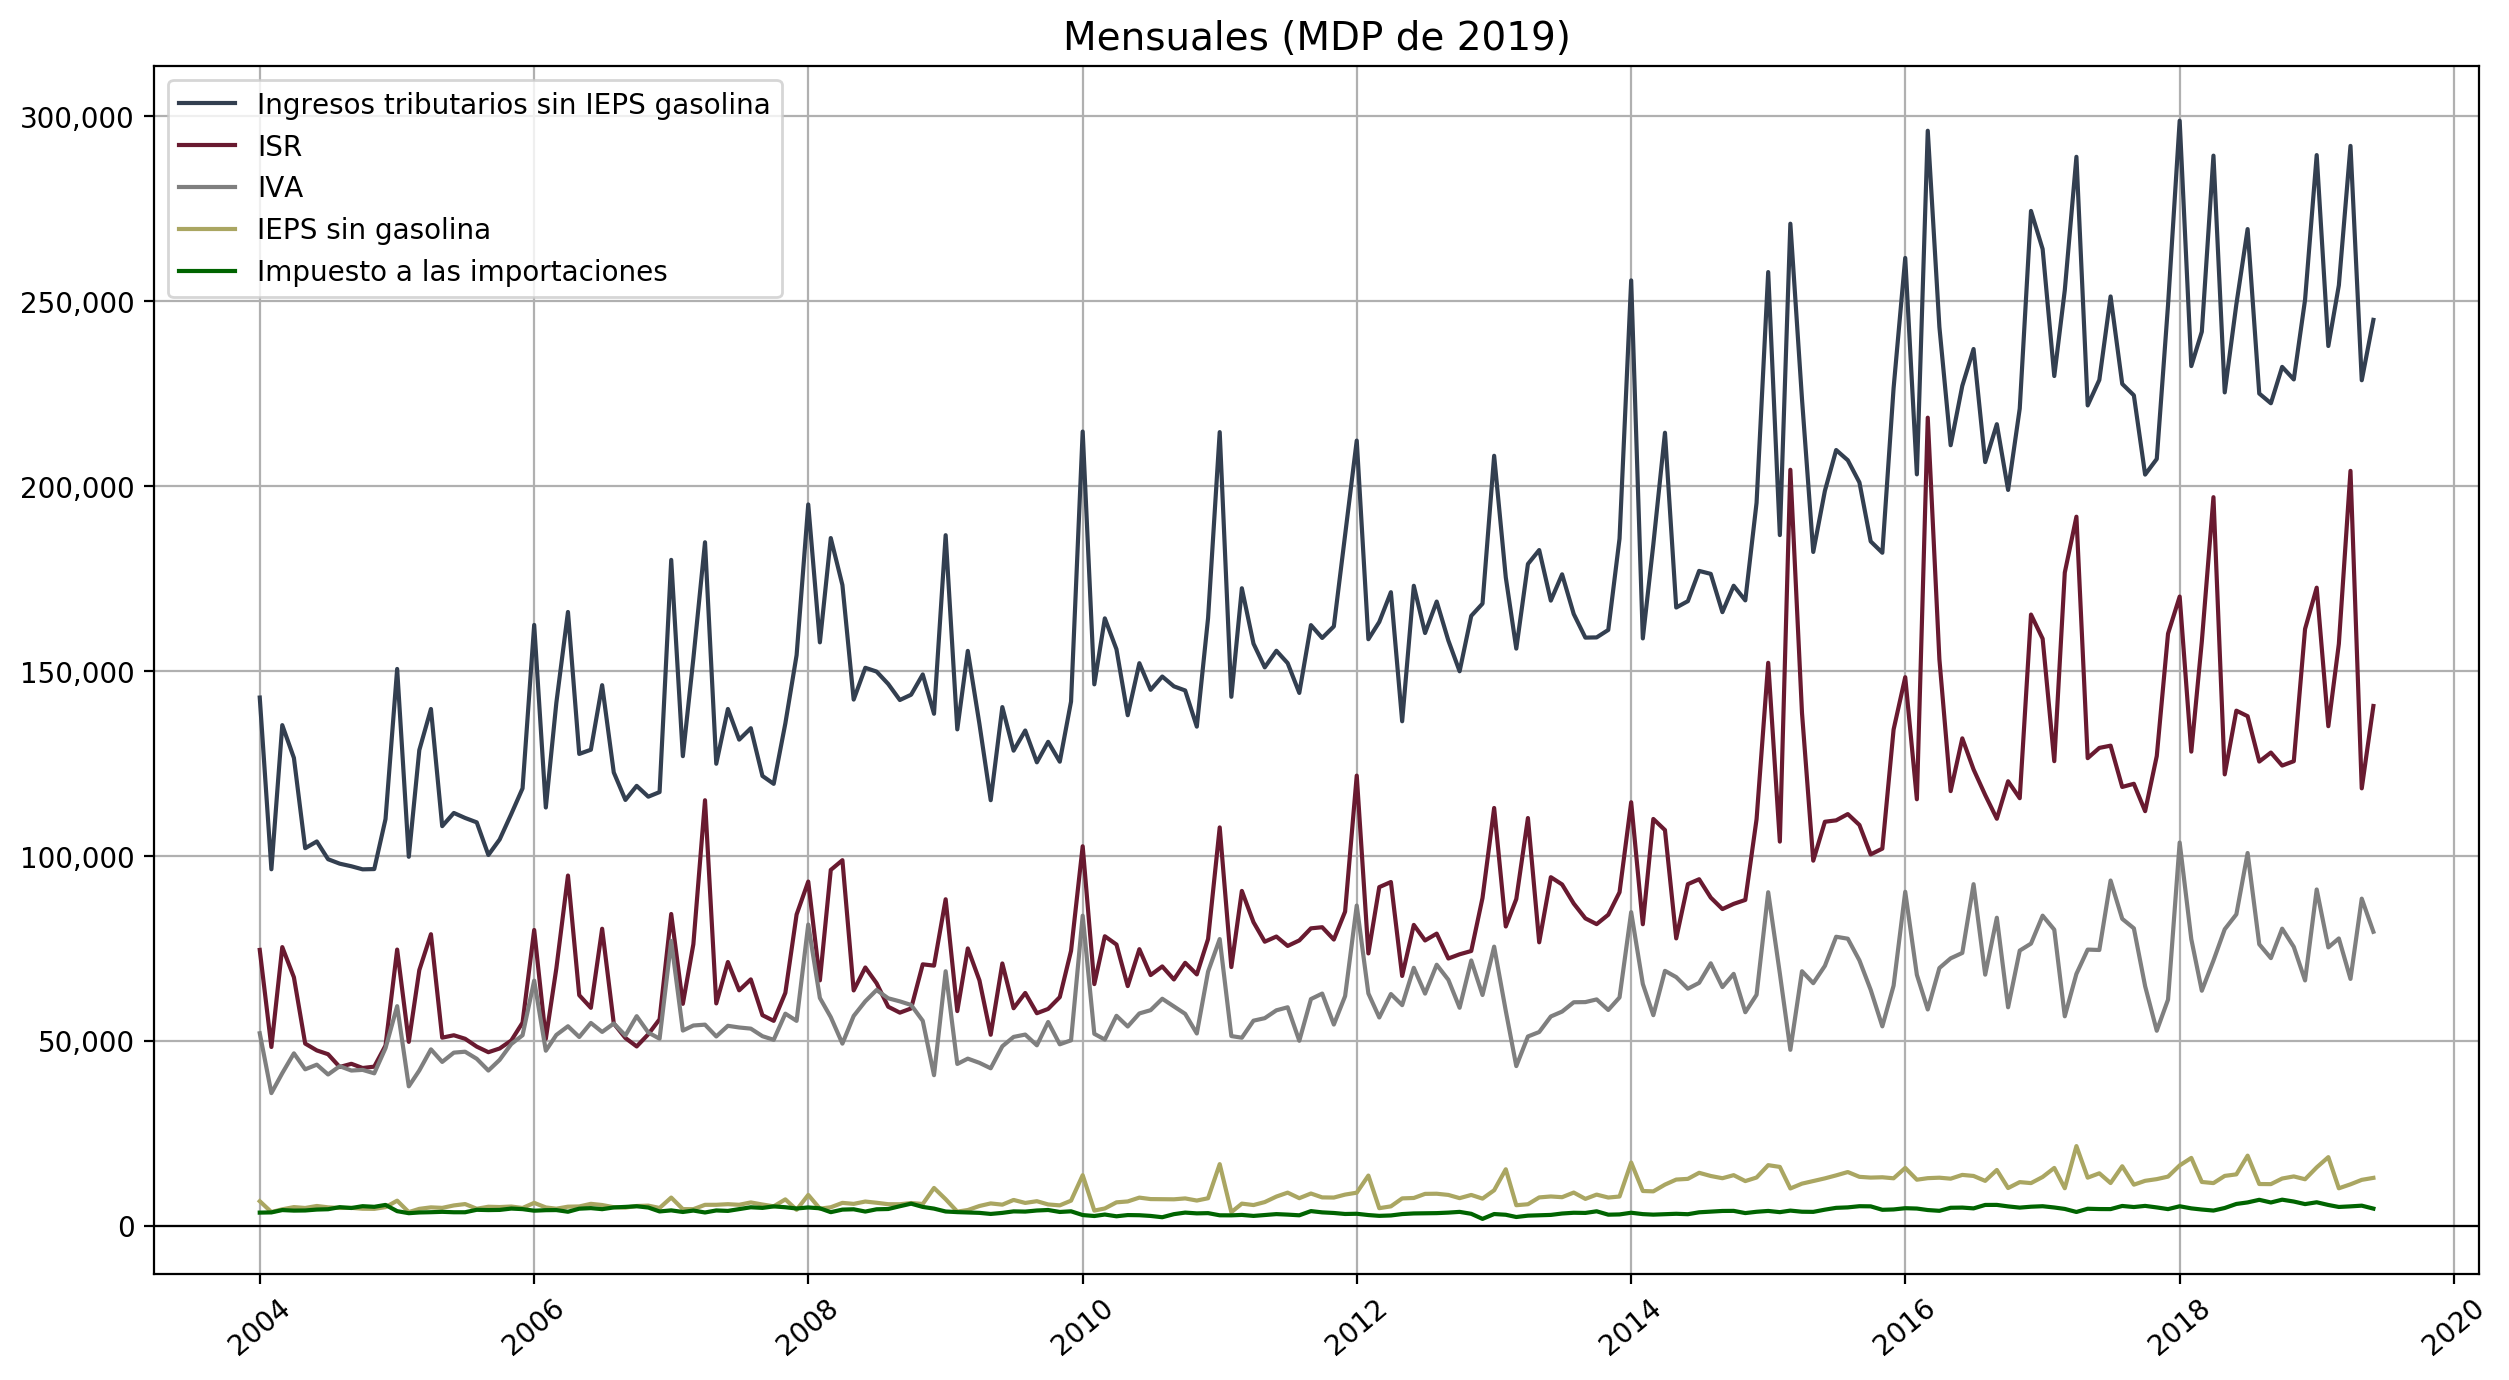

In [65]:
labels = ['Ingresos tributarios sin IEPS gasolina',
          'ISR',
          'IVA', 
          'IEPS sin gasolina',
          'Impuesto a las importaciones']
descriptive.plot_series(ingresos_totales, cols_ingresos_tributarios_relevantes,
                        legend= labels,
                        title='Mensuales (MDP de 2019)', ticks = 'yearly', ticks_freq=2, hline=0,
                        dpi=200,
                        min_date='2004-01-01')

### Análisis anual

In [66]:
pib_r = download.load_pib_r(monthly=True)
pib_r_yearly = pib_r.resample('YS').mean()
ingresos_totales_yearly = ingresos_totales.resample('YS').sum()
ingresos_totales_yearly = ingresos_totales_yearly.loc[ingresos_totales_yearly.index < '2019-01-01']
pib_r_yearly = pib_r.loc[pib_r.index < '2019-01-01']
yearly_df = pd.merge(ingresos_totales_yearly, pib_r_yearly, left_index=True, right_index=True)

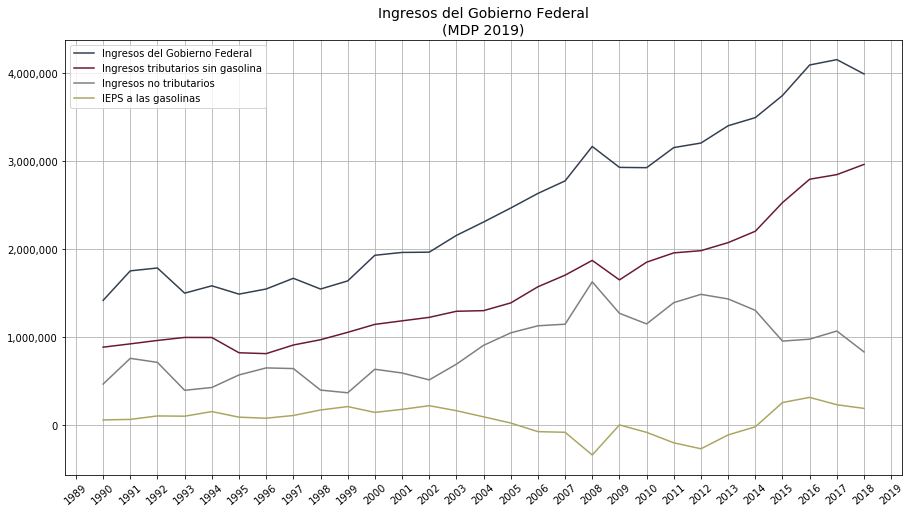

In [67]:
labels = ['Ingresos del Gobierno Federal',
          'Ingresos tributarios sin gasolina',
          'Ingresos no tributarios',
          'IEPS a las gasolinas']
descriptive.plot_series(yearly_df, cols_ingresos_gob_federal, 'Ingresos del Gobierno Federal', 
                        '(MDP 2019)', legend=labels, ticks = 'yearly', ticks_freq=1)

In [68]:
yearly_df.loc['2018-01-01', cols_ingresos_gob_federal + ['ing_trib_neto_(mdp)_r']]

ing_gob_fed_neto_(mdp)_r           3.992219e+06
ing_trib_sin_gasol_neto_(mdp)_r    2.964762e+06
ing_no_trib_neto_(mdp)_r           8.343658e+05
ieps_gasolina_neto_(mdp)_r         1.930912e+05
ing_trib_neto_(mdp)_r              3.157853e+06
Name: 2018-01-01 00:00:00, dtype: float64

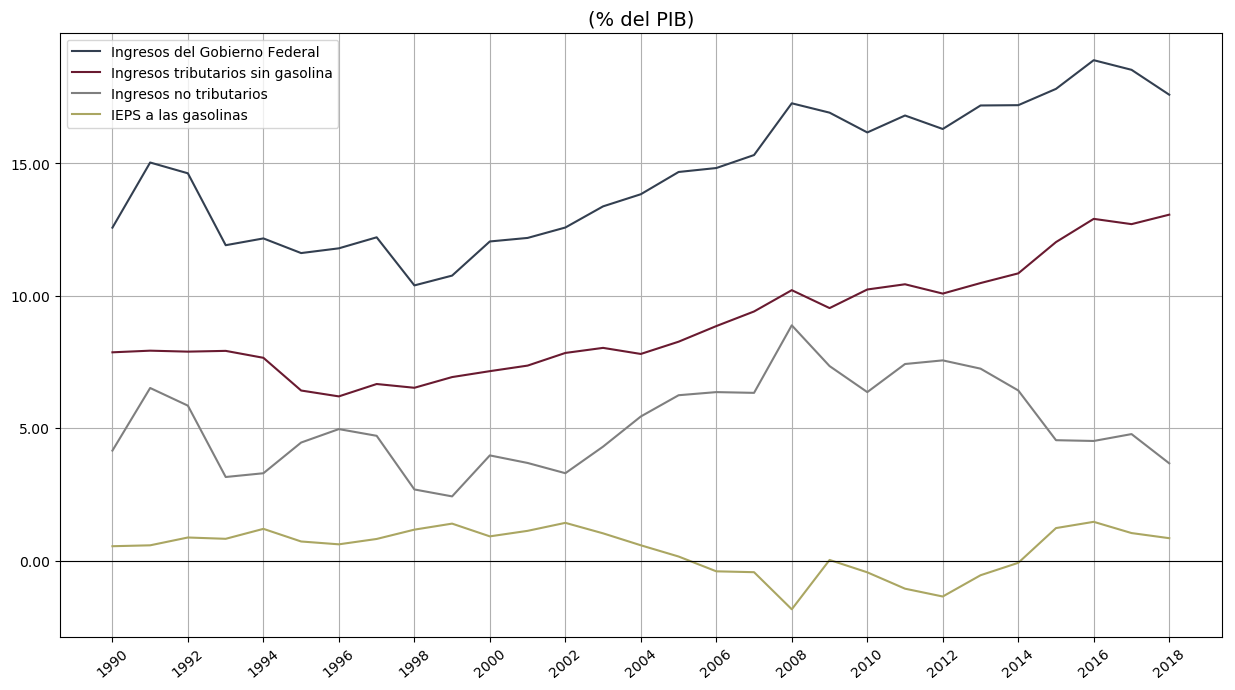

In [69]:
labels = ['Ingresos del Gobierno Federal',
          'Ingresos tributarios sin gasolina',
          'Ingresos no tributarios',
          'IEPS a las gasolinas']
descriptive.plot_series(df=yearly_df.div(yearly_df['pibr_2019'], axis=0) * 100, 
                        cols=cols_ingresos_gob_federal, 
                        title='(% del PIB)',
                        legend=labels, ticks = 'yearly', ticks_freq=2, hline=0, dpi=100,
                       save_to='../reporte/figures/ingresos_gob_fed.png')

In [70]:
(yearly_df.div(yearly_df['pibr_2019'], axis=0) * 100).loc['2018-01-01', cols_ingresos_gob_federal+ ['ing_trib_neto_(mdp)_r']]

ing_gob_fed_neto_(mdp)_r           17.594586
ing_trib_sin_gasol_neto_(mdp)_r    13.066357
ing_no_trib_neto_(mdp)_r            3.677234
ieps_gasolina_neto_(mdp)_r          0.850995
ing_trib_neto_(mdp)_r              13.917353
Name: 2018-01-01 00:00:00, dtype: float64

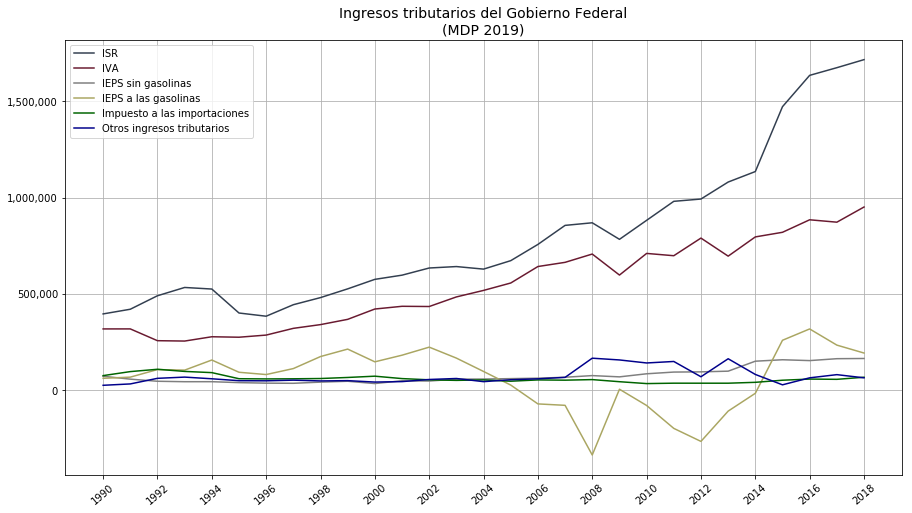

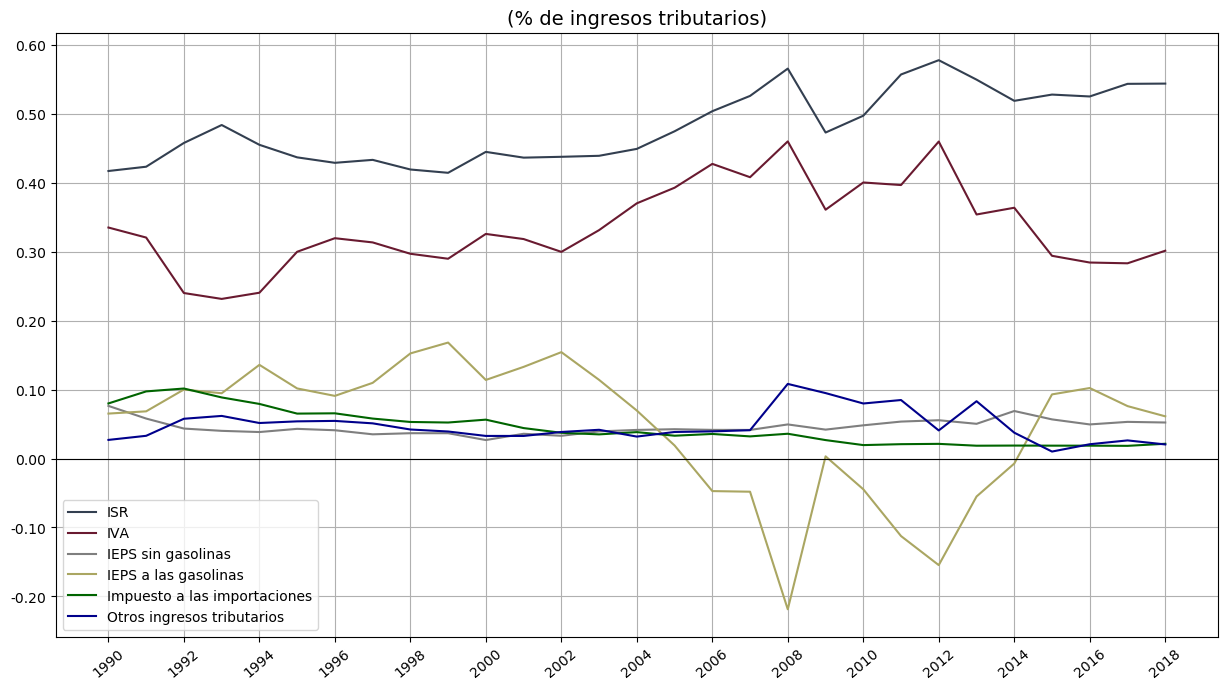

isr_neto_(mdp)_r                           1.716680e+06
iva_neto_(mdp)_r                           9.513947e+05
ieps_sin_gas_neto_(mdp)_r                  1.648314e+05
ieps_gasolina_neto_(mdp)_r                 1.930912e+05
importaciones_neto_(mdp)_r                 6.746572e+04
otros_ingresos_tributarios_neto_(mdp)_r    6.438951e+04
Name: 2018-01-01 00:00:00, dtype: float64

isr_neto_(mdp)_r                           0.543623
iva_neto_(mdp)_r                           0.301279
ieps_sin_gas_neto_(mdp)_r                  0.052197
ieps_gasolina_neto_(mdp)_r                 0.061146
importaciones_neto_(mdp)_r                 0.021364
otros_ingresos_tributarios_neto_(mdp)_r    0.020390
Name: 2018-01-01 00:00:00, dtype: float64

In [89]:
labels_solo_impuestos = ['ISR', 'IVA', 'IEPS sin gasolinas',
                         'IEPS a las gasolinas',
                         'Impuesto a las importaciones',
                         'Otros ingresos tributarios']

descriptive.plot_series(yearly_df, cols_solo_impuestos,
                        'Ingresos tributarios del Gobierno Federal', 
                        '(MDP 2019)', legend=labels_solo_impuestos, 
                        ticks = 'yearly', ticks_freq=2)
descriptive.plot_series(yearly_df.div(yearly_df['ing_trib_neto_(mdp)_r'], axis=0), 
                        cols_solo_impuestos,
                        '(% de ingresos tributarios)', 
                        legend=labels_solo_impuestos, 
                        ticks = 'yearly', ticks_freq=2, hline=0, dpi=100,
                        save_to='../reporte/figures/impuestos_perc_trib.png')
display(yearly_df.loc['2018-01-01', cols_solo_impuestos])
display(yearly_df.div(yearly_df['ing_trib_neto_(mdp)_r'], axis=0).loc['2018-01-01', cols_solo_impuestos])

### Análisis mensual

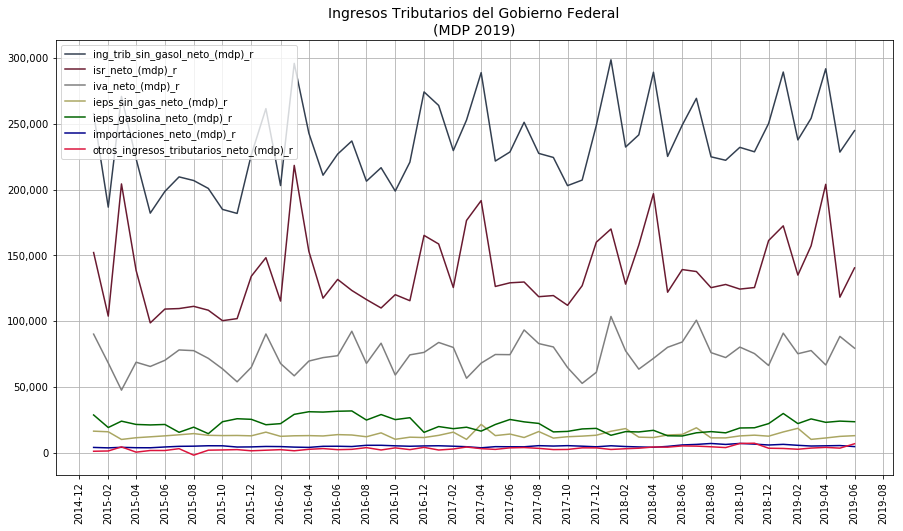

In [15]:
descriptive.plot_series(ingresos_totales, cols_ingresos_tributarios_principales,
                        'Ingresos Tributarios del Gobierno Federal', 
                        '(MDP 2019)', ticks = 'monthly', ticks_freq=2, min_date='2015-01-01')

## Decomposition Naive

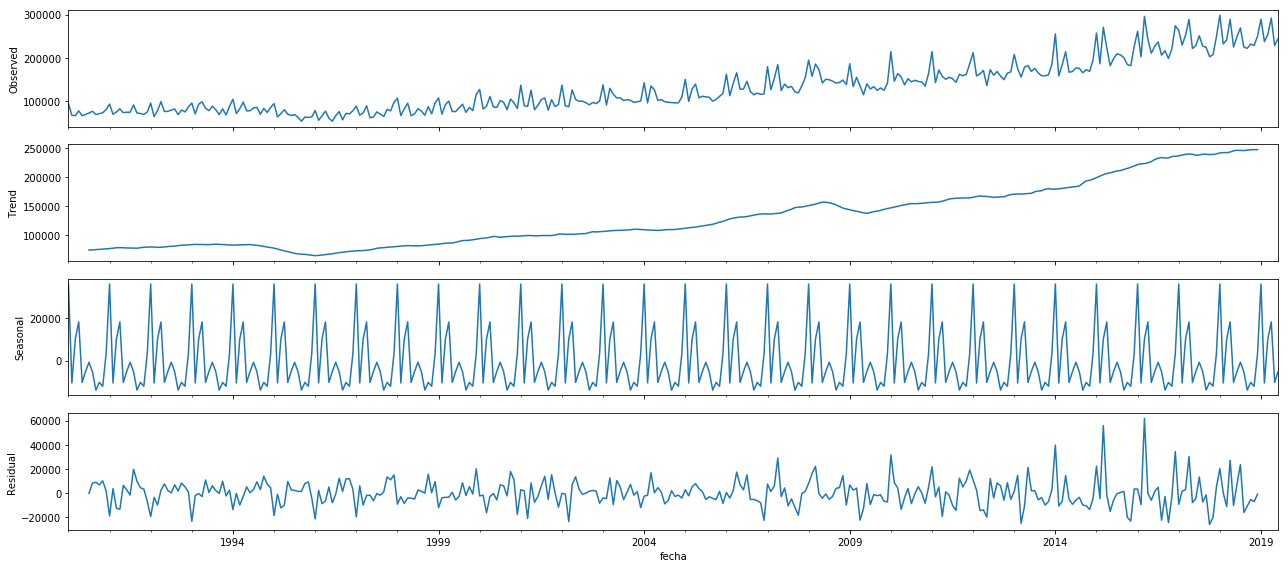

In [16]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ingresos_totales[params['outcome_col']], model='additive')
fig = decomposition.plot()
plt.show()

### Zoom a estacionalidad

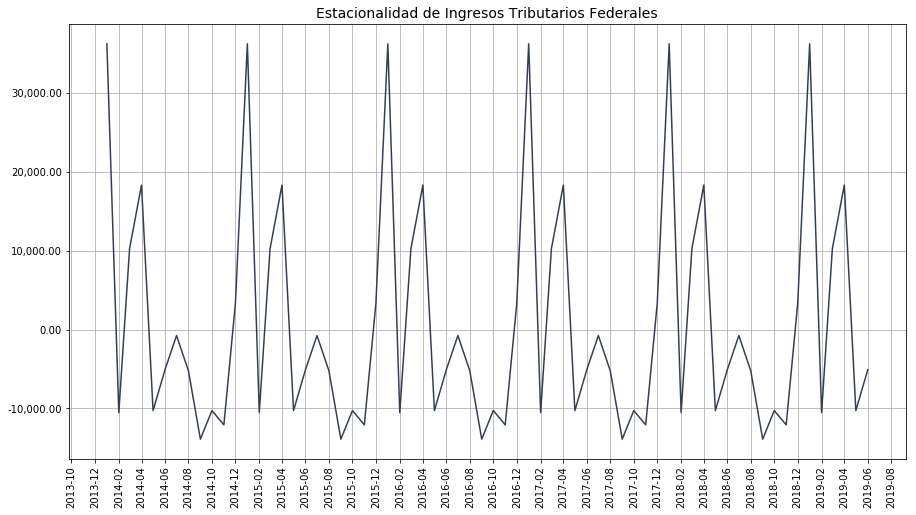

In [17]:
descriptive.plot_series(decomposition.seasonal, title='Estacionalidad de Ingresos Tributarios Federales',
                        figsize=(15, 8), legend=False, ticks = 'monthly',
                        ticks_freq= 2, min_date= '2014-01-01')

Se ve tendencia positiva de ingresos fiscales, así como fuerte componente estacional.Diciembre y Enero son los meses con mayores ingresos, Febrero siempre tiene una caida muy fuerte. Marzo es también de altos ingresos, y los demás meses se mantienen oscilando en niveles bajos y medios. 

## Hodrick Prescot

In [18]:
cycle, trend = sm.tsa.filters.hpfilter(ingresos_totales[params['outcome_col']], 129600)
hp_decomp = ingresos_totales[[params['outcome_col']]].copy()
hp_decomp["cycle"] = cycle
hp_decomp["trend"] = trend

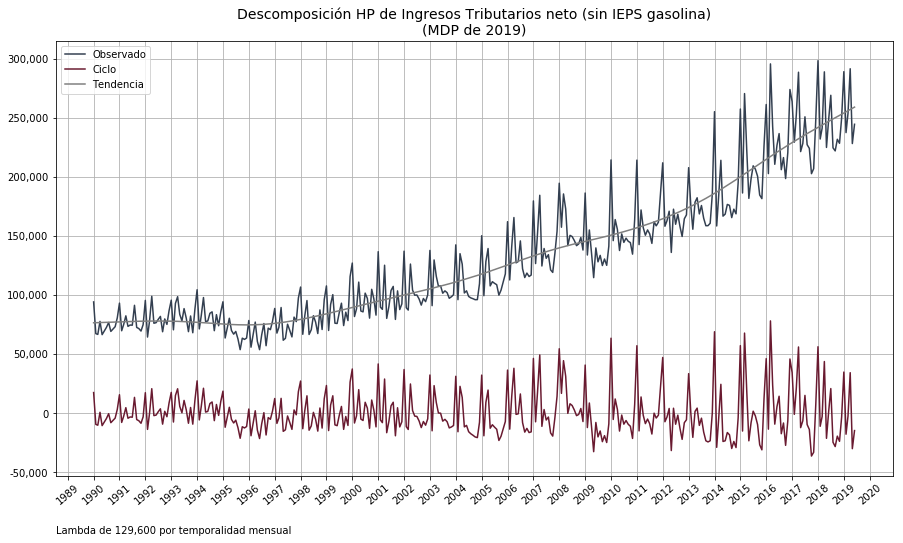

In [19]:
descriptive.plot_series(hp_decomp,
                        title='Descomposición HP de {}'.format(params['nombre_legible']),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

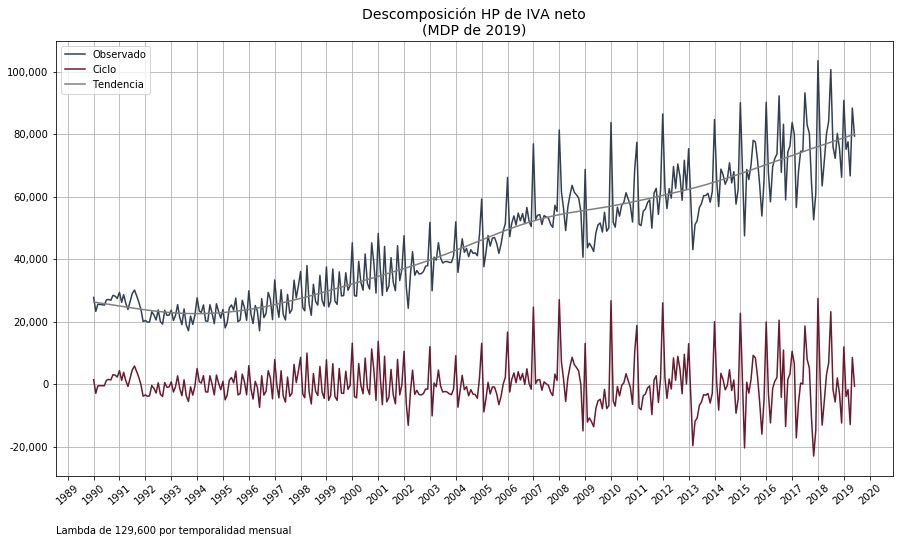

In [20]:
cycle_isr, trend_isr = sm.tsa.filters.hpfilter(ingresos_totales['iva_neto_(mdp)_r'], 129600)
hp_decomp_isr = ingresos_totales[['iva_neto_(mdp)_r']].copy()
hp_decomp_isr["cycle"] = cycle_isr
hp_decomp_isr["trend"] = trend_isr
descriptive.plot_series(hp_decomp_isr,
                        title='Descomposición HP de {}'.format('IVA neto'),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

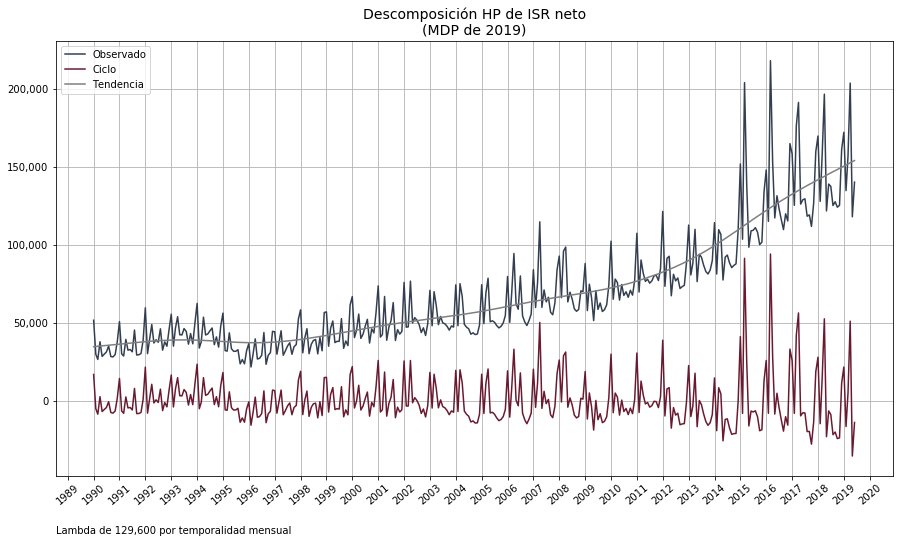

In [21]:
cycle_isr, trend_isr = sm.tsa.filters.hpfilter(ingresos_totales['isr_neto_(mdp)_r'], 129600)
hp_decomp_isr = ingresos_totales[['isr_neto_(mdp)_r']].copy()
hp_decomp_isr["cycle"] = cycle_isr
hp_decomp_isr["trend"] = trend_isr
descriptive.plot_series(hp_decomp_isr,
                        title='Descomposición HP de {}'.format('ISR neto'),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

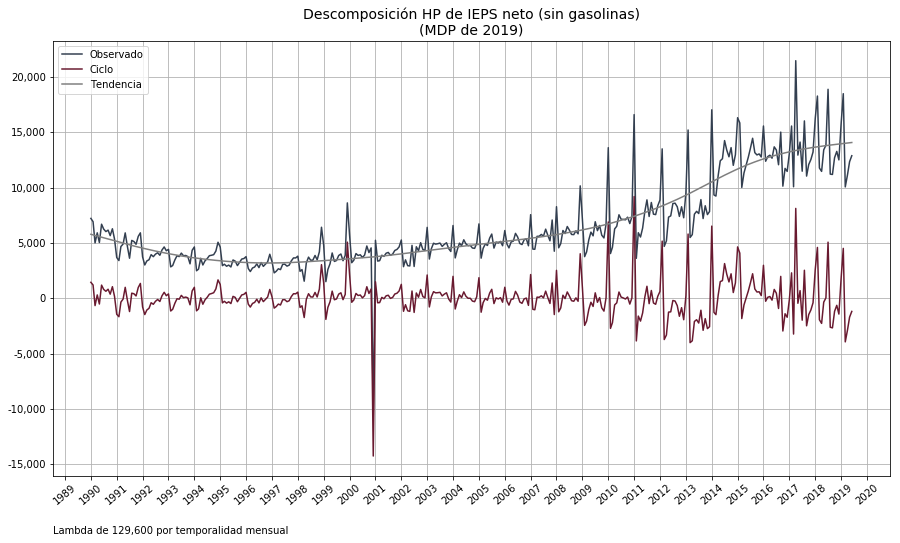

In [22]:
cycle_ieps, trend_ieps = sm.tsa.filters.hpfilter(ingresos_totales['ieps_sin_gas_neto_(mdp)_r'], 129600)
hp_decomp_ieps = ingresos_totales[['ieps_sin_gas_neto_(mdp)_r']].copy()
hp_decomp_ieps["cycle"] = cycle_ieps
hp_decomp_ieps["trend"] = trend_ieps
descriptive.plot_series(hp_decomp_ieps,
                        title='Descomposición HP de {}'.format('IEPS neto (sin gasolinas)'),
                        subtitle='(MDP de 2019)',
                        legend=['Observado', 'Ciclo', 'Tendencia'],
                        figsize=(15, 8), ticks='yearly',
                        footnote='Lambda de 129,600 por temporalidad mensual')

### Zoom a estacionalidad

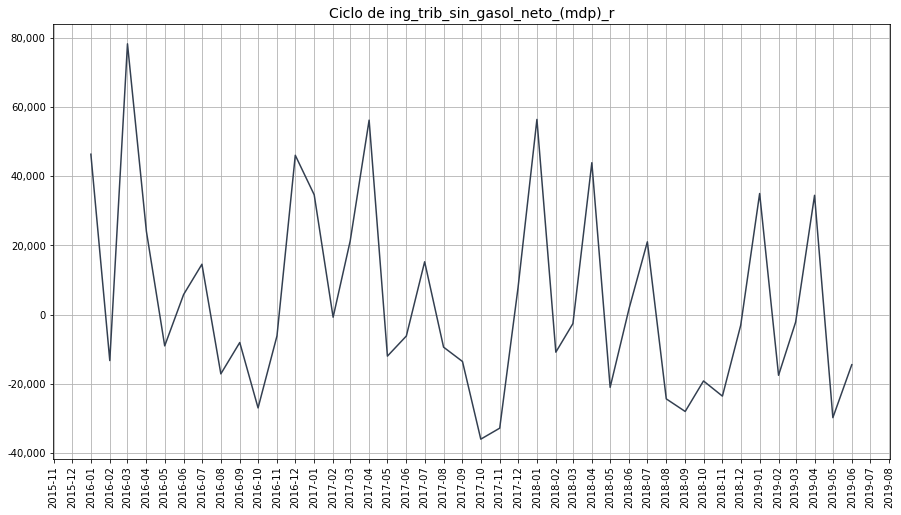

In [23]:
descriptive.plot_series(cycle, title='Ciclo de {}'.format(params['outcome_col']),
                        figsize=(15, 8), legend=False, ticks = 'monthly',
                        ticks_freq= 1, min_date= '2016-01-01')

## Testing for stationarity and transforming

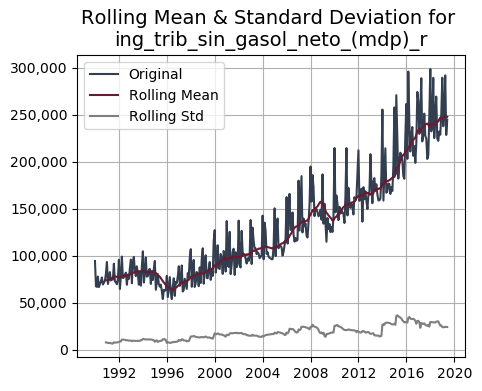

Results of Dickey-Fuller Test:
Test Statistic                   1.664995
p-value                          0.998040
# Lags Used                     14.000000
Number of Observations Used    339.000000
Critical Value (1%)             -3.449788
Critical Value (5%)             -2.870104
Critical Value (10%)            -2.571332
dtype: float64


In [24]:
descriptive.test_stationarity(ingresos_totales[params['outcome_col']])


 
 TRANSFORMATION log 



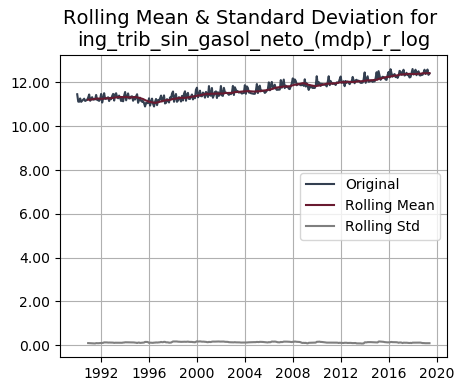

Results of Dickey-Fuller Test:
Test Statistic                   0.353548
p-value                          0.979672
# Lags Used                     14.000000
Number of Observations Used    339.000000
Critical Value (1%)             -3.449788
Critical Value (5%)             -2.870104
Critical Value (10%)            -2.571332
dtype: float64

 
 TRANSFORMATION diff 



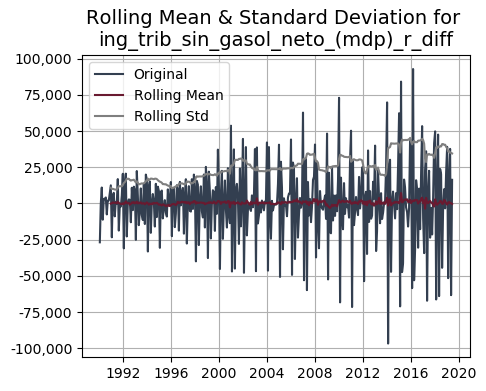

Results of Dickey-Fuller Test:
Test Statistic                -6.037489e+00
p-value                        1.370951e-07
# Lags Used                    1.300000e+01
Number of Observations Used    3.390000e+02
Critical Value (1%)           -3.449788e+00
Critical Value (5%)           -2.870104e+00
Critical Value (10%)          -2.571332e+00
dtype: float64

 
 TRANSFORMATION log_diff 



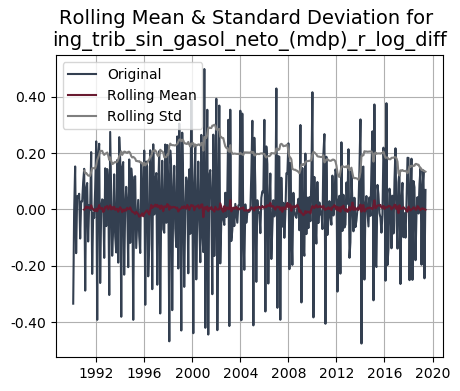

Results of Dickey-Fuller Test:
Test Statistic                  -5.430965
p-value                          0.000003
# Lags Used                     13.000000
Number of Observations Used    339.000000
Critical Value (1%)             -3.449788
Critical Value (5%)             -2.870104
Critical Value (10%)            -2.571332
dtype: float64


In [25]:
transforms = ['log', 'diff', 'log_diff']
for t in transforms:
    print('\n \n TRANSFORMATION {} \n'.format(t))
    new_serie_name = params['outcome_col'] + '_' + t
    ingresos_totales[new_serie_name] = descriptive.transformation(ingresos_totales[params['outcome_col']], t)
    descriptive.test_stationarity(ingresos_totales[new_serie_name])

## Stationarity results
- level: Not stationary
- log: Not stationary
- diff: Stationary
- log_diff: Stationary

Vamos a usar log diff para el análisis